# Task overview

You are predicting whether a given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0.

# Data overview

Each sample in the train and test set has the following information:

- The text of a tweet
- A keyword from that tweet (although this may be blank!)
- The location the tweet was sent from (may also be blank)

**Importing libraries**

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module="jupyter")
warnings.filterwarnings("ignore", category=DeprecationWarning)

**Loading data**

In [3]:
sns.set_style("whitegrid")

try:
    train_df = pd.read_csv("../data/raw/train.csv")
    test_df = pd.read_csv("../data/raw/test.csv")
    print("Data loaded successfully")
except FileNotFoundError:
    print("File not found. Please check the path.")

Data loaded successfully


In [4]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


**Basic EDA**

In [5]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("\n##################### Types #####################")
    print(dataframe.dtypes)
    print("\n##################### Missing Values #####################")
    print(dataframe.isnull().sum())
    print("\n##################### Duplicates #####################")
    print(dataframe.duplicated().sum())


check_df(train_df)

##################### Shape #####################
(7613, 5)

##################### Types #####################
id          int64
keyword       str
location      str
text          str
target      int64
dtype: object

##################### Missing Values #####################
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

##################### Duplicates #####################
0


C:\Users\37529\AppData\Local\Temp\ipykernel_5796\1258838379.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=missing_df, x='pct', y='column', palette='YlOrRd')


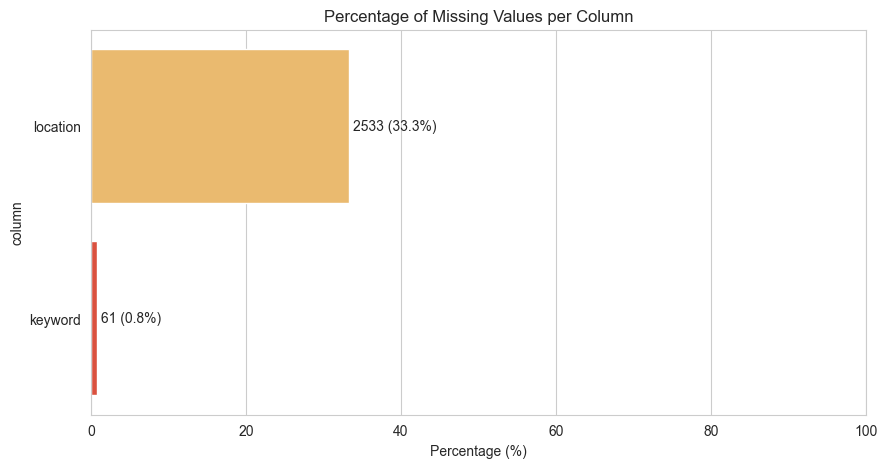

In [6]:
def plot_missing_values(df):
    missing_data = df.isnull().sum()
    missing_pct = (missing_data / len(df)) * 100
    missing_df = pd.DataFrame(
        {"column": missing_data.index, "count": missing_data.values, "pct": missing_pct.values}
    )
    missing_df = missing_df[missing_df["count"] > 0].sort_values("count", ascending=False)

    if missing_df.empty:
        print("No missing values found.")
        return

    plt.figure(figsize=(10, 5))
    sns.barplot(data=missing_df, x="pct", y="column", palette="YlOrRd")
    for i, row in enumerate(missing_df.itertuples()):
        plt.text(row.pct + 0.5, i, f"{row.count} ({row.pct:.1f}%)", va="center")  # type: ignore

    plt.title("Percentage of Missing Values per Column")
    plt.xlabel("Percentage (%)")
    plt.xlim(0, 100)
    plt.show()


plot_missing_values(train_df)

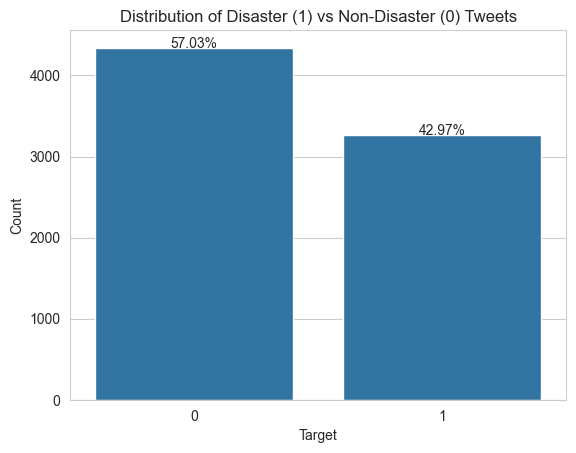

In [7]:
total = len(train_df)
ax = sns.countplot(x="target", data=train_df)

for p in ax.patches:
    height = p.get_height()  # type: ignore
    ax.text(
        p.get_x() + p.get_width() / 2.0,  # type: ignore
        height + 3,
        "{:1.2f}%".format((height / total) * 100),
        ha="center",
    )

plt.title("Distribution of Disaster (1) vs Non-Disaster (0) Tweets")
plt.xlabel("Target")
plt.ylabel("Count")
plt.show()

*Inconsistent labels*

In [8]:
duplicate_texts = train_df[train_df.duplicated(subset=["text"], keep=False)]
print("Number of text duplicates:", duplicate_texts.shape[0])

inconsistent = duplicate_texts.groupby("text")["target"].nunique()
inconsistent_texts = inconsistent[inconsistent > 1].index
print("Removing", len(inconsistent_texts), "inconsistent texts")

train_df_clean = train_df[~train_df["text"].isin(inconsistent_texts)].copy()
print("New shape:", train_df_clean.shape)

Number of text duplicates: 179
Removing 18 inconsistent texts
New shape: (7558, 5)


**Tweet analysis**

*Normalization and cleaning before analysis*

In [9]:
from disaster_tweets.preprocessing import extract_features

df_eda = extract_features(train_df_clean)

print(df_eda[["text", "clean_text", "url_count", "top_domain", "typo_count", "has_typos"]].head(10))

df_eda.groupby("target")[["url_count", "typo_count"]].mean()

                                                text  \
0  Our Deeds are the Reason of this #earthquake M...   
1             Forest fire near La Ronge Sask. Canada   
2  All residents asked to 'shelter in place' are ...   
3  13,000 people receive #wildfires evacuation or...   
4  Just got sent this photo from Ruby #Alaska as ...   
5  #RockyFire Update => California Hwy. 20 closed...   
6  #flood #disaster Heavy rain causes flash flood...   
7  I'm on top of the hill and I can see a fire in...   
8  There's an emergency evacuation happening now ...   
9  I'm afraid that the tornado is coming to our a...   

                                          clean_text  url_count top_domain  \
0               deed reason earthquake allah forgive          0        NaN   
1              forest fire near la ronge sask canada          0        NaN   
2  resident ask shelter place notify officer evac...          0        NaN   
3  13000 people receive wildfire evacuation order...          0        

,url_count,typo_count
target,,
0,0.511245,0.813355
1,0.775655,0.771032


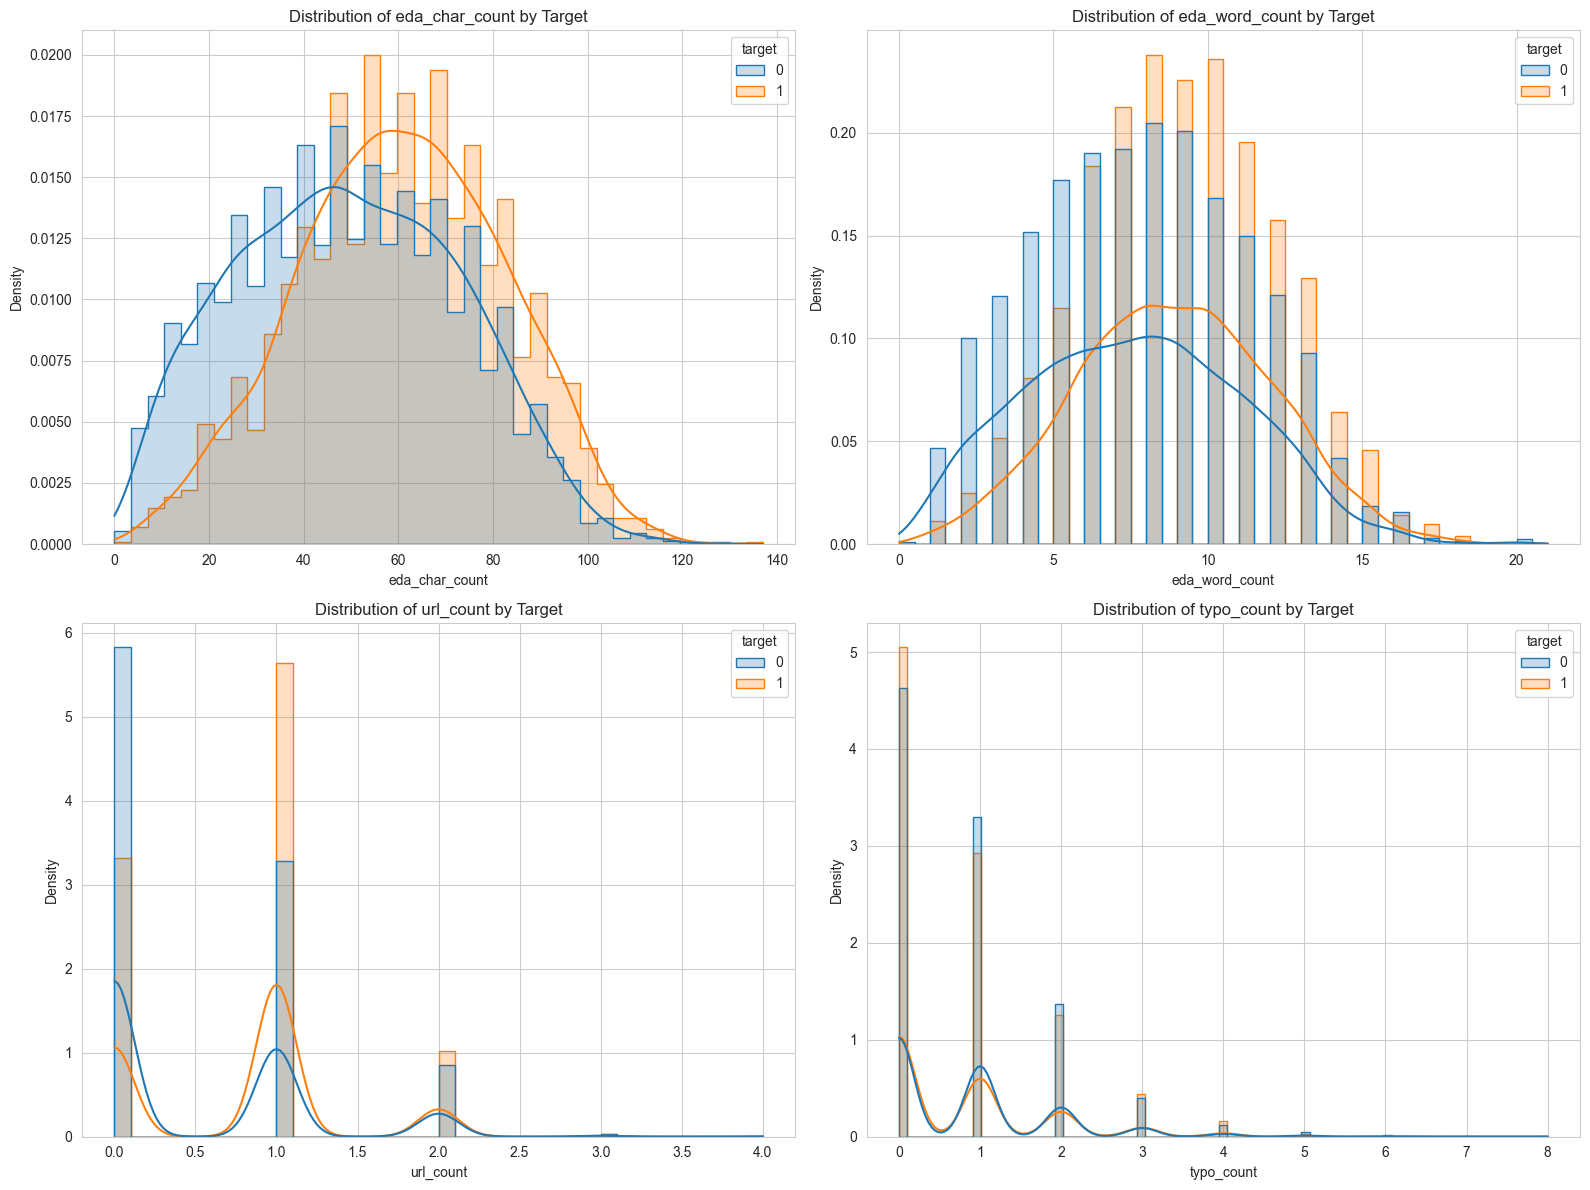

In [10]:
df_eda["eda_char_count"] = df_eda["clean_text"].str.len()
df_eda["eda_word_count"] = df_eda["clean_text"].str.split().apply(len)

meta_features = ["eda_char_count", "eda_word_count", "url_count", "typo_count"]

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i, feature in enumerate(meta_features):
    sns.histplot(
        data=df_eda,
        x=feature,
        hue="target",
        kde=True,
        element="step",
        stat="density",
        common_norm=False,
        ax=axes[i],
    )
    axes[i].set_title(f"Distribution of {feature} by Target")

plt.tight_layout()
plt.show()

**N-gram analysis**

In [11]:
def plot_top_ngrams(corpus, title, n_gram=1, top_k=20):
    vec = CountVectorizer(stop_words="english", ngram_range=(n_gram, n_gram), min_df=5).fit(corpus)

    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)  # type: ignore
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:top_k]
    df_plot = pd.DataFrame(words_freq, columns=["Word", "Count"])
    plt.figure(figsize=(12, 6))
    sns.barplot(data=df_plot, x="Count", y="Word")
    plt.title(title)
    plt.show()

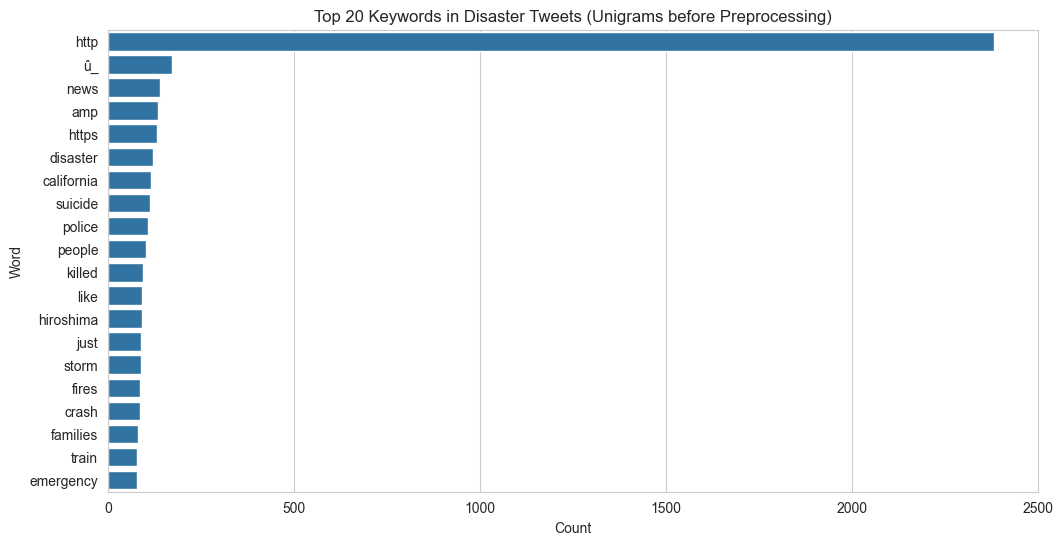

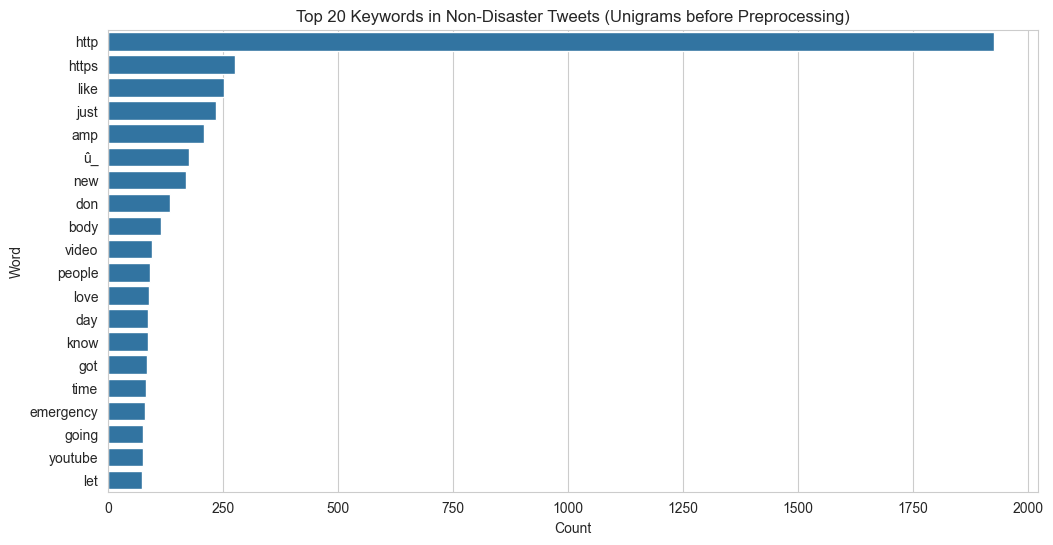

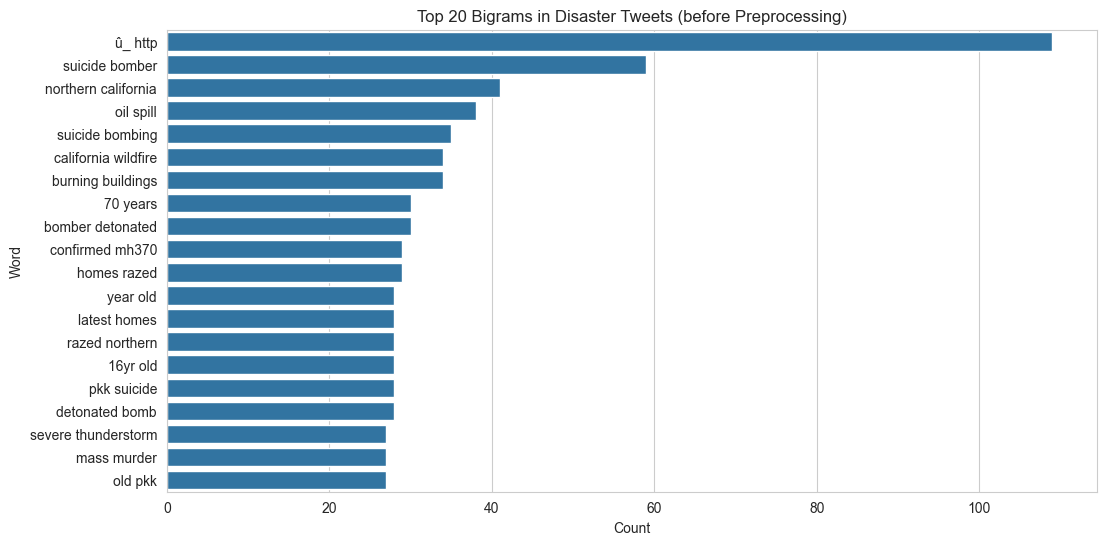

In [12]:
disaster_text = df_eda[df_eda["target"] == 1]["text"]
non_disaster_text = df_eda[df_eda["target"] == 0]["text"]

plot_top_ngrams(
    disaster_text, "Top 20 Keywords in Disaster Tweets (Unigrams before Preprocessing)", n_gram=1
)
plot_top_ngrams(
    non_disaster_text,
    "Top 20 Keywords in Non-Disaster Tweets (Unigrams before Preprocessing)",
    n_gram=1,
)
plot_top_ngrams(disaster_text, "Top 20 Bigrams in Disaster Tweets (before Preprocessing)", n_gram=2)

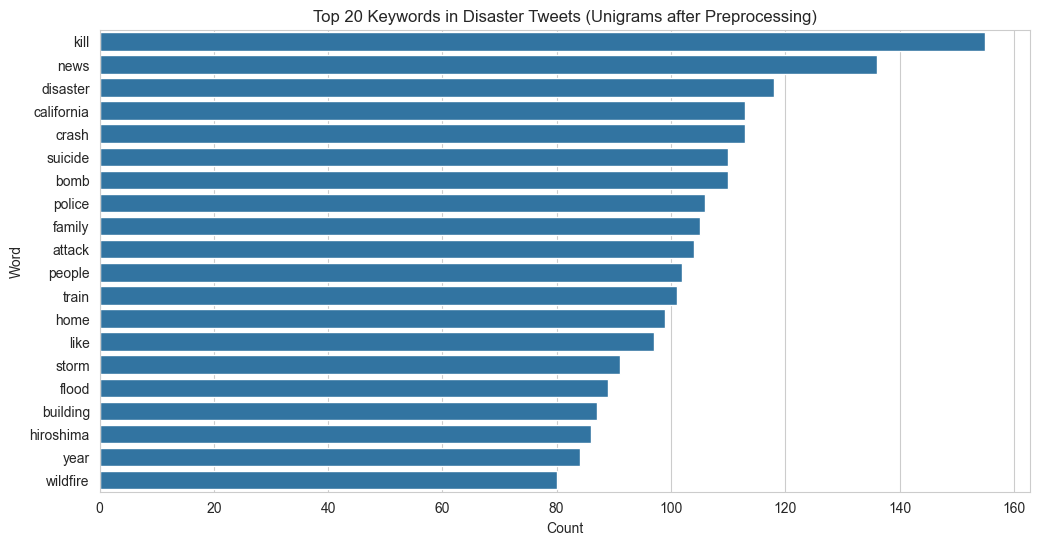

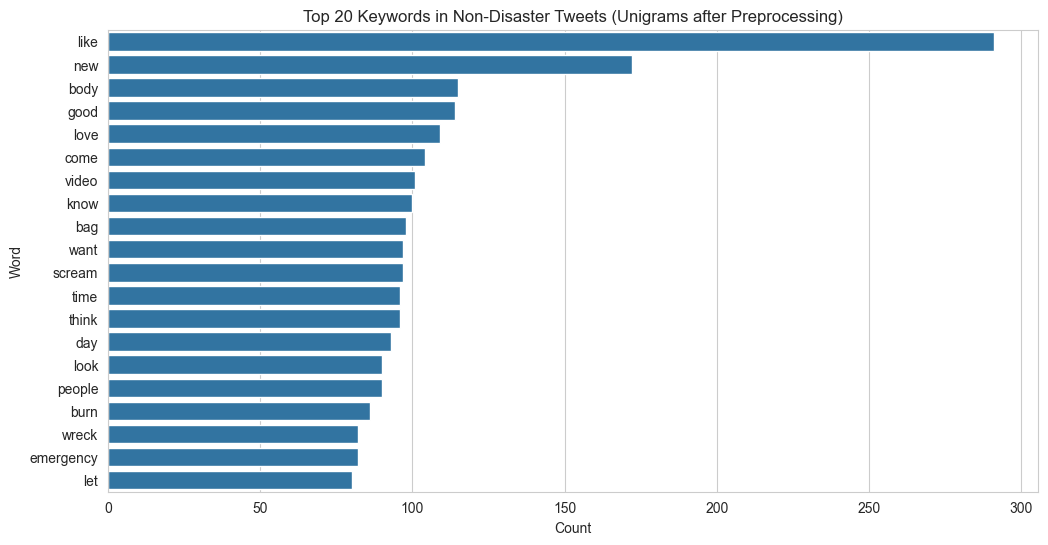

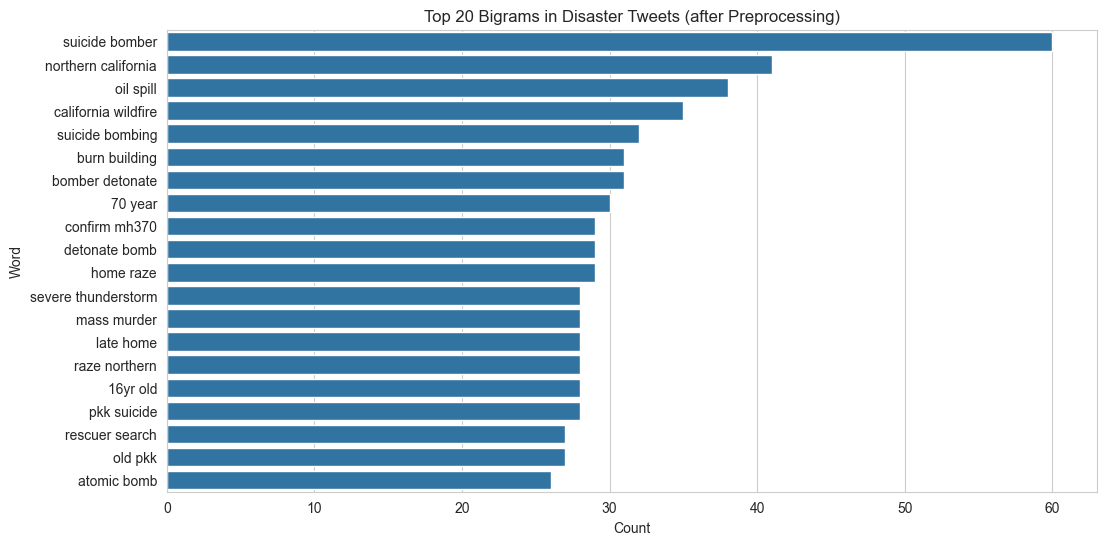

In [13]:
disaster_text = df_eda[df_eda["target"] == 1]["clean_text"]
non_disaster_text = df_eda[df_eda["target"] == 0]["clean_text"]

plot_top_ngrams(
    disaster_text, "Top 20 Keywords in Disaster Tweets (Unigrams after Preprocessing)", n_gram=1
)
plot_top_ngrams(
    non_disaster_text,
    "Top 20 Keywords in Non-Disaster Tweets (Unigrams after Preprocessing)",
    n_gram=1,
)
plot_top_ngrams(disaster_text, "Top 20 Bigrams in Disaster Tweets (after Preprocessing)", n_gram=2)

**Location and keyword analysis**

In [14]:
top_keywords = df_eda["keyword"].value_counts().head(20)
print("Top 20 keywords overall:\n", top_keywords)

top_keywords_disaster = df_eda[df_eda["target"] == 1]["keyword"].value_counts().head(20)
print("\nTop 20 keywords in disaster tweets:\n", top_keywords_disaster)

top_keywords_non_disaster = df_eda[df_eda["target"] == 0]["keyword"].value_counts().head(20)
print("\nTop 20 keywords in non-disaster tweets:\n", top_keywords_non_disaster)

Top 20 keywords overall:
 keyword
fatalities     45
armageddon     42
deluge         42
body%20bags    41
damage         41
harm           41
collided       40
evacuate       40
fear           40
outbreak       40
siren          40
twister        40
windstorm      40
collision      39
derailment     39
earthquake     39
explosion      39
famine         39
flames         39
sinkhole       39
Name: count, dtype: int64

Top 20 keywords in disaster tweets:
 keyword
derailment               39
outbreak                 39
wreckage                 39
debris                   37
oil%20spill              37
typhoon                  37
evacuated                32
rescuers                 32
suicide%20bomb           32
suicide%20bombing        32
nuclear%20disaster       31
razed                    31
airplane%20accident      30
earthquake               30
suicide%20bomber         30
bridge%20collapse        29
collision                29
wildfire                 29
buildings%20on%20fire    28
ca

C:\Users\37529\AppData\Local\Temp\ipykernel_5796\3564845033.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_keywords_disaster.values, y=top_keywords_disaster.index, palette="viridis")


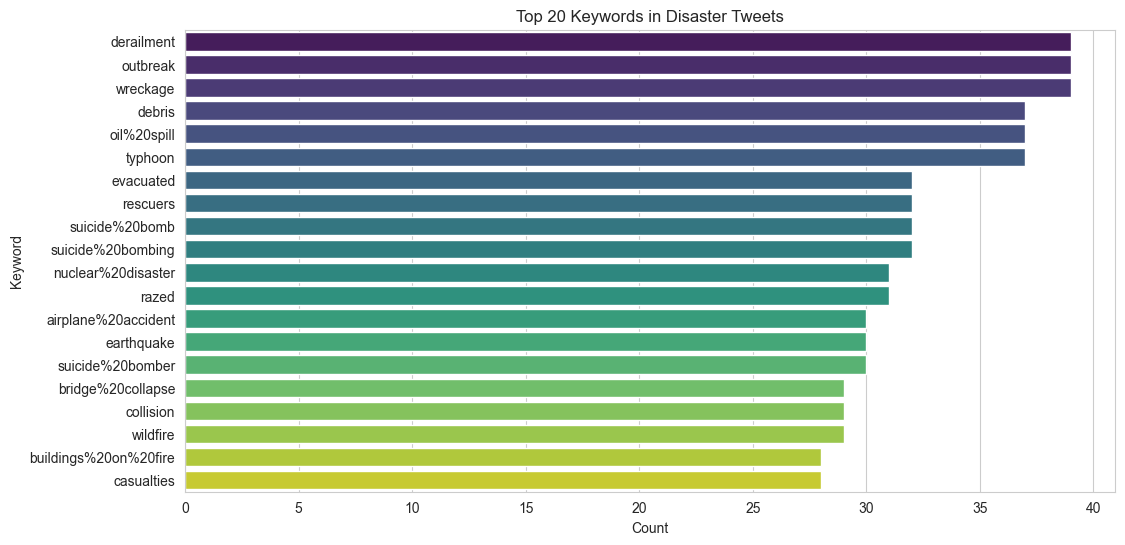

In [15]:
plt.figure(figsize=(12, 6))
sns.barplot(x=top_keywords_disaster.values, y=top_keywords_disaster.index, palette="viridis")
plt.title("Top 20 Keywords in Disaster Tweets")
plt.xlabel("Count")
plt.ylabel("Keyword")
plt.show()

C:\Users\37529\AppData\Local\Temp\ipykernel_5796\2146508980.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


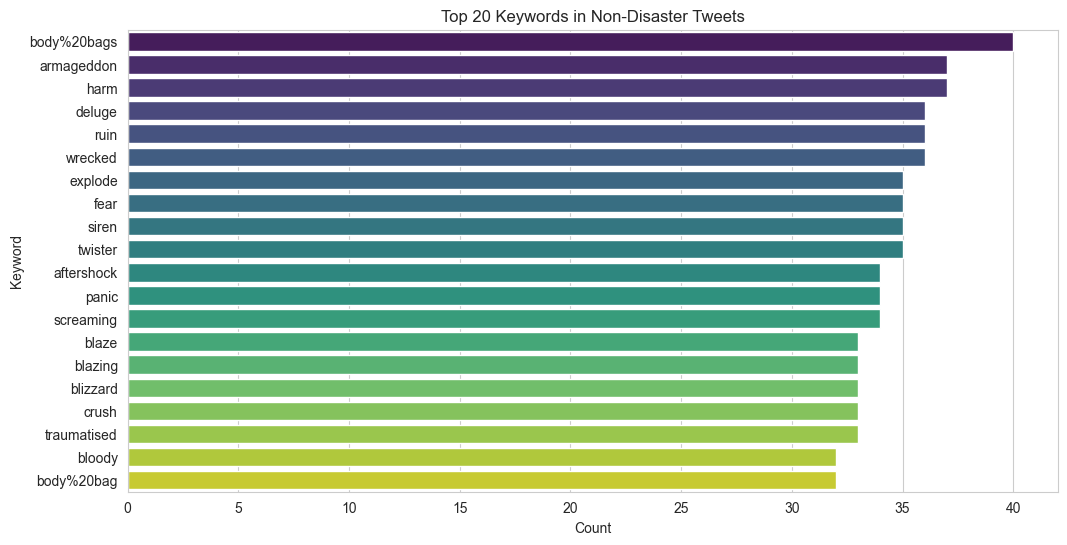

In [16]:
plt.figure(figsize=(12, 6))
sns.barplot(
    x=top_keywords_non_disaster.values, y=top_keywords_non_disaster.index, palette="viridis"
)
plt.title("Top 20 Keywords in Non-Disaster Tweets")
plt.xlabel("Count")
plt.ylabel("Keyword")
plt.show()

In [17]:
top_locations = df_eda["location"].value_counts().head(20)
print("\nTop 20 locations overall:\n", top_locations)

top_locations_disaster = df_eda[df_eda["target"] == 1]["location"].value_counts().head(20)
print("\nTop 20 locations in disaster tweets:\n", top_locations_disaster)

top_locations_non_disaster = df_eda[df_eda["target"] == 0]["location"].value_counts().head(20)
print("\nTop 20 locations in non-disaster tweets:\n", top_locations_non_disaster)


Top 20 locations overall:
 location
                   2504
usa                 105
new york             77
united states        50
london               50
nigeria              35
canada               34
uk                   30
worldwide            29
india                28
los angeles, ca      28
mumbai               24
california           21
washington, dc       21
kenya                21
everywhere           20
chicago, il          20
australia            19
new york, ny         17
los angeles          16
Name: count, dtype: int64

Top 20 locations in disaster tweets:
 location
                    1065
usa                   67
nigeria               28
united states         27
india                 22
mumbai                19
worldwide             18
new york              18
uk                    17
canada                17
london                17
washington, dc        15
australia             10
washington, d.c.      10
chicago, il           10
indonesia              9
earth    

C:\Users\37529\AppData\Local\Temp\ipykernel_5796\3986294582.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_locations_disaster.values, y=top_locations_disaster.index, palette="viridis")


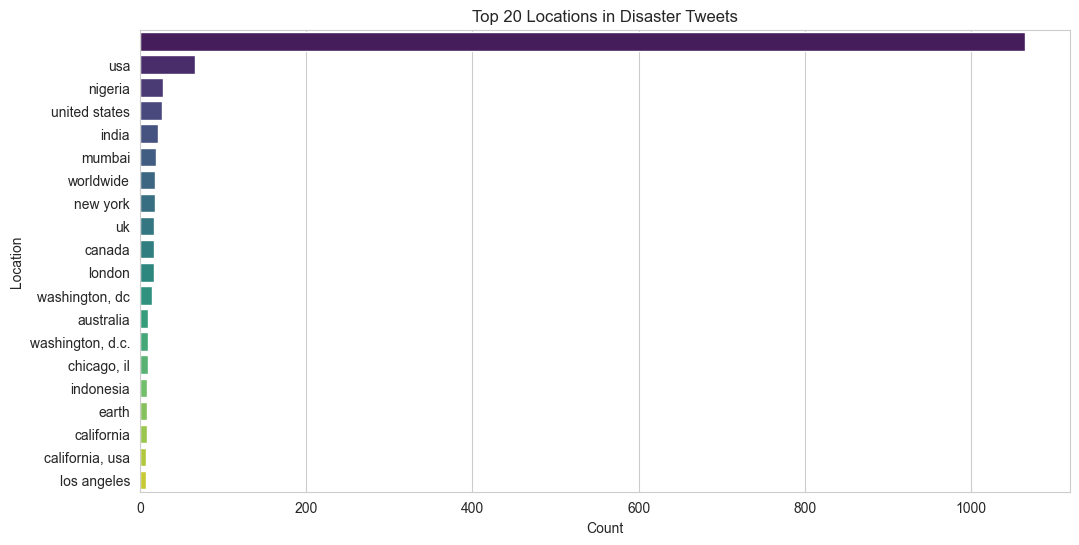

In [18]:
plt.figure(figsize=(12, 6))
sns.barplot(x=top_locations_disaster.values, y=top_locations_disaster.index, palette="viridis")
plt.title("Top 20 Locations in Disaster Tweets")
plt.xlabel("Count")
plt.ylabel("Location")
plt.show()

C:\Users\37529\AppData\Local\Temp\ipykernel_5796\2781602417.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


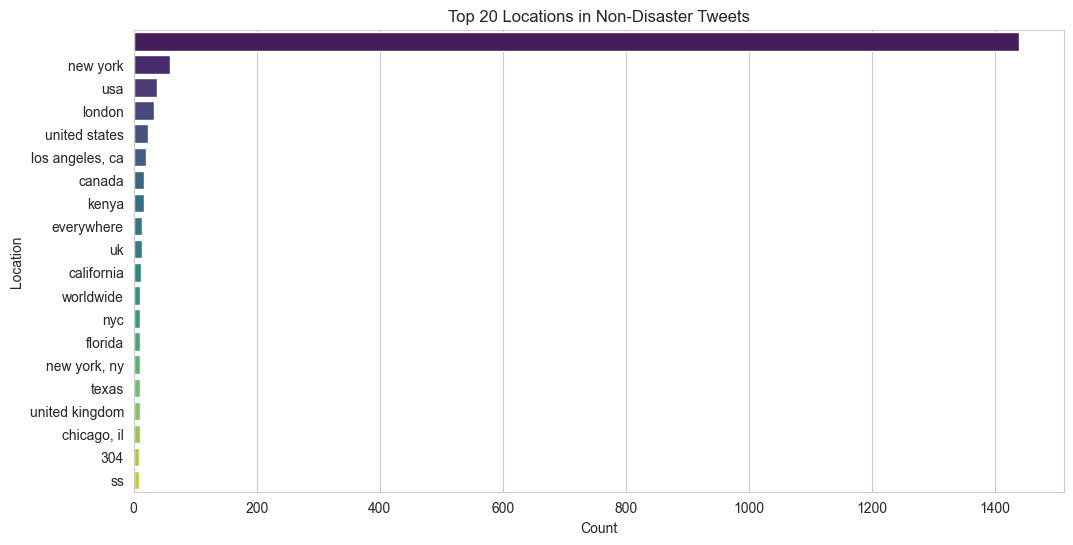

In [19]:
plt.figure(figsize=(12, 6))
sns.barplot(
    x=top_locations_non_disaster.values, y=top_locations_non_disaster.index, palette="viridis"
)
plt.title("Top 20 Locations in Non-Disaster Tweets")
plt.xlabel("Count")
plt.ylabel("Location")
plt.show()

*Missing location + keyword analysis*

In [20]:
df_eda["keyword_na"] = df_eda["keyword"].isna()
df_eda["location_na"] = df_eda["location"].isna()
df_eda["both_na"] = df_eda["keyword_na"] & df_eda["location_na"]

df_eda["text_len"] = df_eda["text"].str.len()
df_eda["word_count"] = df_eda["text"].str.split().str.len()
df_eda["has_url"] = df_eda["text"].str.contains(r"http|www\.|https", regex=True, na=False)
df_eda["has_mention"] = df_eda["text"].str.contains(r"@\w+", regex=True, na=False)
df_eda["has_hashtag"] = df_eda["text"].str.contains(r"#\w+", regex=True, na=False)

In [21]:
print("Missing rate by target (0 = non-disaster, 1 = disaster):")
miss_by_target = df_eda.groupby("target")[["keyword_na", "location_na", "both_na"]].mean() * 100
print(miss_by_target.round(2))

Missing rate by target (0 = non-disaster, 1 = disaster):
        keyword_na  location_na  both_na
target                                  
0             0.44          0.0      0.0
1             1.29          0.0      0.0


In [22]:
print("Average text length and word count by missing combinations:")
len_by_miss = (
    df_eda.groupby(["keyword_na", "location_na"], observed=True)[["text_len", "word_count"]]
    .mean()
    .round(1)
)
len_by_miss.columns = ["avg char length", "avg word count"]
print(len_by_miss)

Average text length and word count by missing combinations:
                        avg char length  avg word count
keyword_na location_na                                 
False      False                  101.2            14.9
True       False                   73.9            11.4


In [23]:
print("Percentage of tweets with URL / @ / # by missing combinations:")
media_by_miss = (
    df_eda.groupby(["keyword_na", "location_na"], observed=True)[
        ["has_url", "has_mention", "has_hashtag"]
    ].mean()
    * 100
)
print(media_by_miss.round(1))

Percentage of tweets with URL / @ / # by missing combinations:
                        has_url  has_mention  has_hashtag
keyword_na location_na                                   
False      False           52.6         26.8         22.6
True       False           32.8          3.3         32.8


In [24]:
print("Top 12 keywords when location is missing (including NaN):")
print(df_eda[df_eda["location_na"]]["keyword"].value_counts(dropna=False).head(12))

Top 12 keywords when location is missing (including NaN):
Series([], Name: count, dtype: int64)


In [25]:
print("Top 12 locations when keyword is missing (including NaN):")
print(df_eda[df_eda["keyword_na"]]["location"].value_counts(dropna=False).head(12))

Top 12 locations when keyword is missing (including NaN):
location
    61
Name: count, dtype: int64


In [26]:
both_na_texts = df_eda[df_eda["both_na"]]["text"]
print(f"Number of tweets where both keyword and location are missing: {len(both_na_texts)}")

if len(both_na_texts) > 0:
    print("\nRandom sample of texts where both are missing:")
    print(both_na_texts.sample(min(10, len(both_na_texts))).tolist())

Number of tweets where both keyword and location are missing: 0


C:\Users\37529\AppData\Local\Temp\ipykernel_5796\140588958.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=miss_by_target.index, y=miss_by_target['keyword_na'], ax=ax[0], palette="viridis")
C:\Users\37529\AppData\Local\Temp\ipykernel_5796\140588958.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=miss_by_target.index, y=miss_by_target['location_na'], ax=ax[1], palette="viridis")
C:\Users\37529\AppData\Local\Temp\ipykernel_5796\140588958.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=miss_by_target.index, y=miss_by_target['

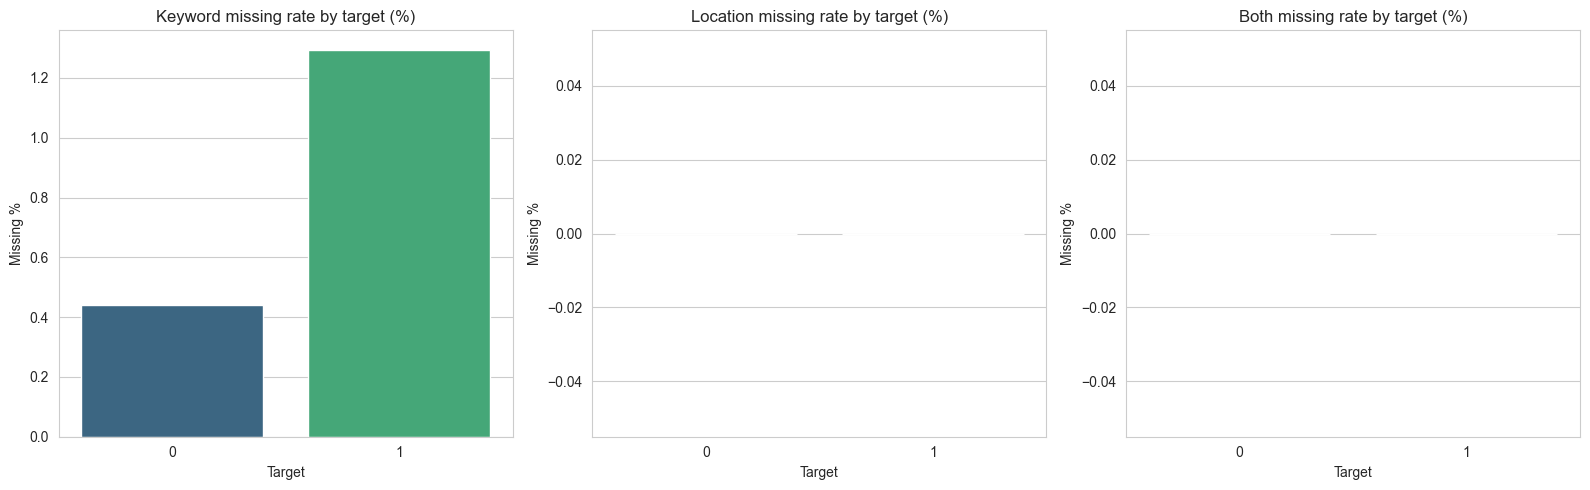

In [27]:
fig, ax = plt.subplots(1, 3, figsize=(16, 5))

sns.barplot(x=miss_by_target.index, y=miss_by_target["keyword_na"], ax=ax[0], palette="viridis")
ax[0].set_title("Keyword missing rate by target (%)")
ax[0].set_xlabel("Target")
ax[0].set_ylabel("Missing %")

sns.barplot(x=miss_by_target.index, y=miss_by_target["location_na"], ax=ax[1], palette="viridis")
ax[1].set_title("Location missing rate by target (%)")
ax[1].set_xlabel("Target")
ax[1].set_ylabel("Missing %")

sns.barplot(x=miss_by_target.index, y=miss_by_target["both_na"], ax=ax[2], palette="viridis")
ax[2].set_title("Both missing rate by target (%)")
ax[2].set_xlabel("Target")
ax[2].set_ylabel("Missing %")

plt.tight_layout()
plt.show()

**Typo analysis**

In [28]:
print("=== Typos Analysis ===")
print("Avg typo_count overall:", df_eda["typo_count"].mean().round(2))  # type: ignore
print("Avg typo_count in disaster:", df_eda[df_eda["target"] == 1]["typo_count"].mean().round(2))  # type: ignore
print(
    "Avg typo_count in non-disaster:",
    df_eda[df_eda["target"] == 0]["typo_count"].mean().round(2),  # type: ignore
)
print("\nHas typos distribution:\n", df_eda["has_typos"].value_counts(normalize=True))

=== Typos Analysis ===
Avg typo_count overall: 0.8
Avg typo_count in disaster: 0.77
Avg typo_count in non-disaster: 0.81

Has typos distribution:
 has_typos
0    0.938476
1    0.061524
Name: proportion, dtype: float64


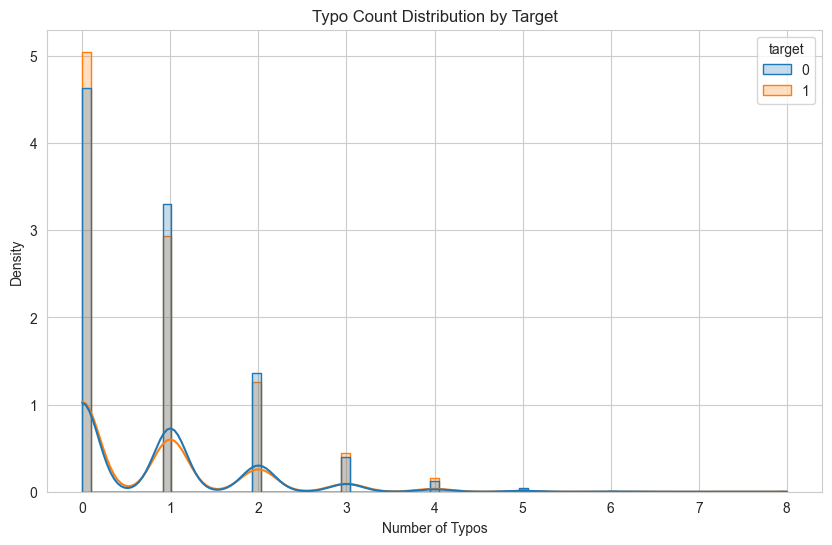

In [29]:
plt.figure(figsize=(10, 6))
sns.histplot(
    data=df_eda,
    x="typo_count",
    hue="target",
    kde=True,
    element="step",
    stat="density",
    common_norm=False,
)
plt.title("Typo Count Distribution by Target")
plt.xlabel("Number of Typos")
plt.ylabel("Density")
plt.show()

C:\Users\37529\AppData\Local\Temp\ipykernel_5796\2130446169.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mean_typos.index, y=mean_typos.values, palette="viridis")


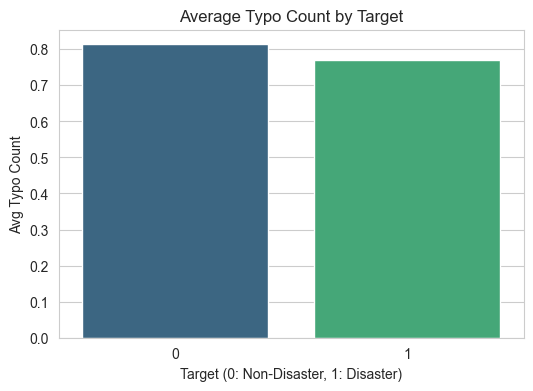

In [30]:
mean_typos = df_eda.groupby("target")["typo_count"].mean()
plt.figure(figsize=(6, 4))
sns.barplot(x=mean_typos.index, y=mean_typos.values, palette="viridis")
plt.title("Average Typo Count by Target")
plt.xlabel("Target (0: Non-Disaster, 1: Disaster)")
plt.ylabel("Avg Typo Count")
plt.show()

In [31]:
print(
    "\nTypo count correlation with meta features:\n",
    df_eda[["typo_count", "url_count"]].corr()["typo_count"],
)


Typo count correlation with meta features:
 typo_count    1.000000
url_count     0.012561
Name: typo_count, dtype: float64


**Preprocessing sanity check**

In [32]:
print("Sample of processed data:")
print(
    df_eda[
        [
            "text",
            "clean_text",
            "url_count",
            "top_domain",
            "has_url",
            "typo_count",
            "location",
            "location_normalized",
        ]
    ].head(10)
)

Sample of processed data:
                                                text  \
0  Our Deeds are the Reason of this #earthquake M...   
1             Forest fire near La Ronge Sask. Canada   
2  All residents asked to 'shelter in place' are ...   
3  13,000 people receive #wildfires evacuation or...   
4  Just got sent this photo from Ruby #Alaska as ...   
5  #RockyFire Update => California Hwy. 20 closed...   
6  #flood #disaster Heavy rain causes flash flood...   
7  I'm on top of the hill and I can see a fire in...   
8  There's an emergency evacuation happening now ...   
9  I'm afraid that the tornado is coming to our a...   

                                          clean_text  url_count top_domain  \
0               deed reason earthquake allah forgive          0        NaN   
1              forest fire near la ronge sask canada          0        NaN   
2  resident ask shelter place notify officer evac...          0        NaN   
3  13000 people receive wildfire evacuation o

In [33]:
sample = df_eda.sample(5, random_state=42)
for idx, row in sample.iterrows():
    print(f"Original: {row['text']}")
    print(f"Cleaned:  {row['clean_text']}")
    print(f"Location: {row['location']} → {row['location_normalized']}")
    print("-" * 80)

Original: Came across this fire video not mine..enjoy..#fire #firemen #firetruck #emergency #rescue #911 #summertime #sirensÛ_ http://t.co/hcYAJsAcfJ
Cleaned:  come fire video mineenjoyfire fireman firetruck emergency rescue summertime sirensû
Location: five down from the coffeeshop → five down from the coffeeshop
--------------------------------------------------------------------------------
Original: When high fashion and food collide: Gucci has chosen one of ShanghaiÛªs most popular commercial avenue... http://t.co/MkRxQZeHmY #fashion
Cleaned:  high fashion food collide gucci choose shanghaiûªs popular commercial avenue fashion
Location: usa → usa
--------------------------------------------------------------------------------
Original: I would like to electrocute everyone who uses the word 'fair' in connection with income tax policies. - William F. Buckley Jr.
Cleaned:  like electrocute use word fair connection income tax policy william buckley jr
Location: texas, usa → usa
----

In [34]:
print("Preprocessing summary:")
print("Average clean_text length:", df_eda["clean_text"].str.len().mean().round(1))  # type: ignore
print("Average typo_count:", df_eda["typo_count"].mean().round(2))  # type: ignore
print("Share with URLs:", (df_eda["has_url"].mean() * 100).round(1), "%")  # type: ignore
print("Share with hashtags:", (df_eda["has_hashtag"].mean() * 100).round(1), "%")  # type: ignore
print("Unique top_domains:", df_eda["top_domain"].nunique())

Preprocessing summary:
Average clean_text length: 54.2
Average typo_count: 0.8
Share with URLs: 52.5 %
Share with hashtags: 22.7 %
Unique top_domains: 2


## Preprocessing Sanity Checks & Additional Analysis

In [ ]:
print("=== Original location formats (top 50 most frequent) ===")
print("Total unique original locations:", train_df_clean["location"].nunique())
print("\nTop 50 most common raw locations:")
print(train_df_clean["location"].value_counts().head(50))

print("\n=== Locations containing city + country hints (sample) ===")
city_country_patterns = train_df_clean[
    train_df_clean["location"]
    .str.lower()
    .str.contains(
        r",|\/|\band\b|\bor\b|\s-\s|uk|usa|united states|great britain|england|russia|canada|france|germany",
        na=False,
        regex=True,
    )
]

print("Examples of city + country / complex locations (first 30 unique):")
print(city_country_patterns["location"].drop_duplicates().head(30).tolist())

print("\n=== Random 20 locations with 'london', 'new york', 'nyc' etc. ===")
city_samples = train_df_clean[
    train_df_clean["location"]
    .str.lower()
    .str.contains("london|new york|nyc|tokyo|moscow|paris|berlin", na=False)
]
print(city_samples["location"].sample(20, random_state=42).tolist())

=== Original location formats (top 50 most frequent) ===
Total unique original locations: 3328

Top 50 most common raw locations:
location
USA                  104
New York              71
United States         50
London                45
Canada                29
Nigeria               28
UK                    27
Los Angeles, CA       26
India                 24
Mumbai                22
Washington, DC        21
Kenya                 20
Worldwide             19
Australia             18
Chicago, IL           18
California            17
New York, NY          15
California, USA       15
Everywhere            15
San Francisco         14
Florida               14
United Kingdom        14
Indonesia             13
Los Angeles           13
Washington, D.C.      13
Toronto               12
NYC                   12
Ireland               12
San Francisco, CA     11
Chicago               11
Earth                 11
Seattle               11
London, UK            10
Texas                 10
New York Ci

In [ ]:
print("=== Checking location normalization: cities with/without country hints ===")

city_patterns = ["london", "new york", "nyc", "moscow", "tokyo", "paris", "berlin"]
location_variants = df_eda[
    df_eda["location"].str.lower().str.contains("|".join(city_patterns), na=False)
]

print(location_variants[["location", "location_normalized"]].drop_duplicates().head(20))

=== Checking location normalization: cities with/without country hints ===
                        location         location_normalized
35                    london, uk                         gbr
169                          nyc                         nyc
173         new york / worldwide        new york / worldwide
211                 new york, ny                         deu
227                       london                      london
302                        tokyo                       tokyo
320                new york city               new york city
359                     new york                    new york
368             harlem, new york            harlem, new york
423      nyc :) ex- #islamophobe         nyc ex- islamophobe
475                      london.                     london.
496     london / st catharines ?      london / st catharines
526   london, kent & se england.    london, kent se england.
768               new york ? atl                new york atl
884       

In [37]:
print("=== Location variants with city + country patterns ===")
variants = df_eda[
    df_eda["location"]
    .str.lower()
    .str.contains(
        "london|new york|nyc|moscow|tokyo|paris|berlin|philadelphia|sao paulo|nairobi", na=False
    )
]
print(variants[["location", "location_normalized"]].drop_duplicates().head(50))

=== Location variants with city + country patterns ===
                          location           location_normalized
34                philadelphia, pa                           pan
35                      london, uk                           gbr
57               sao paulo, brazil                           bra
101                 nairobi, kenya                           ken
169                            nyc                           nyc
173           new york / worldwide          new york / worldwide
211                   new york, ny                           deu
227                         london                        london
302                          tokyo                         tokyo
320                  new york city                 new york city
359                       new york                      new york
368               harlem, new york              harlem, new york
423        nyc :) ex- #islamophobe           nyc ex- islamophobe
475                        london. 

In [39]:
from disaster_tweets.preprocessing import HASHTAG_PATTERN

print("=== Words preceded by hashtags (top 20) ===")

hashtag_words = df_eda["text"].apply(
    lambda x: [w.lower() for w in HASHTAG_PATTERN.findall(str(x))] if pd.notna(x) else []
)
hashtag_words_exploded = hashtag_words.explode()
print(hashtag_words_exploded.value_counts().head(20))

=== Words preceded by hashtags (top 20) ===
text
news          76
hot           31
prebreak      30
best          30
nowplaying    23
hiroshima     22
earthquake    19
gbbo          18
jobs          14
islam         13
job           12
isis          12
world         11
japan         11
hiring        11
terrorism     11
india         10
bbc           10
sismo         10
yyc           10
Name: count, dtype: int64


In [ ]:
print("=== Unique counts BEFORE preprocessing (raw data) ===")

unique_raw_locations = train_df_clean["location"].nunique()
print(f"Unique raw locations (original 'location' column): {unique_raw_locations:,}")

unique_raw_keywords = train_df_clean["keyword"].nunique()
print(f"Unique raw keywords: {unique_raw_keywords:,}")

raw_words = train_df_clean["text"].str.lower().str.split().explode().dropna()
unique_raw_words = raw_words.nunique()
print(f"Unique raw words in 'text' (simple split, no cleaning): {unique_raw_words:,}")

print("\nNote: These are counts from train_df_clean (after removing inconsistent targets)")

=== Unique counts BEFORE preprocessing (raw data) ===
Unique raw locations (original 'location' column): 3,328
Unique raw keywords: 221
Unique raw words in 'text' (simple split, no cleaning): 27,935

Note: These are counts from train_df_clean (after removing inconsistent targets)


In [ ]:
print("=== Comparison: Unique values BEFORE vs AFTER preprocessing ===")

print(f"Unique original locations:          {train_df_clean['location'].nunique():>6}")
print(f"Unique normalized locations:       {df_eda['location_normalized'].nunique():>6}")
print(f"Reduction in unique locations:     {train_df_clean['location'].nunique() - df_eda['location_normalized'].nunique():>6} "
      f"({(1 - df_eda['location_normalized'].nunique() / train_df_clean['location'].nunique())*100:.1f}%)")

print(f"Unique original keywords:          {train_df_clean['keyword'].nunique():>6}")
print(f"Unique keywords after basic cleaning: {df_eda['keyword'].dropna().str.lower().str.replace('%20', ' ').nunique():>6}")

print(f"Unique raw words in text (simple): {train_df_clean['text'].str.lower().str.split().explode().dropna().nunique():>6}")
print(f"Unique lemmas in clean_text:       {df_eda['clean_text'].str.split().explode().dropna().nunique():>6}")
print(f"Reduction in unique words/lemmas:  "
      f"{train_df_clean['text'].str.lower().str.split().explode().dropna().nunique() - df_eda['clean_text'].str.split().explode().dropna().nunique():>6} "
      f"({(1 - df_eda['clean_text'].str.split().explode().dropna().nunique() / train_df_clean['text'].str.lower().str.split().explode().dropna().nunique())*100:.1f}%)")

=== Comparison: Unique values BEFORE vs AFTER preprocessing ===
Unique original locations:            3328
Unique normalized locations:         2386
Reduction in unique locations:        942 (28.3%)
Unique original keywords:             221
Unique keywords after basic cleaning:    221
Unique raw words in text (simple):  27935
Unique lemmas in clean_text:        13217
Reduction in unique words/lemmas:   14718 (52.7%)


In [ ]:
print("=== Top 20 most frequent normalized locations (after preprocessing) ===")
print(df_eda["location_normalized"].value_counts().head(20))

print("\n=== Top 10 normalized countries (only 3-letter codes) ===")
country_only = df_eda[df_eda["location_normalized"].str.len() == 3]["location_normalized"]
print(country_only.value_counts().head(10))

=== Top 20 most frequent normalized locations (after preprocessing) ===
location_normalized
usa           313
can           208
gbr           108
deu            80
new york       77
ind            59
nga            57
aus            52
london         50
isr            43
ncl            40
ken            33
pan            31
gab            31
worldwide      30
tun            26
vat            25
mumbai         24
idn            22
california     21
Name: count, dtype: int64

=== Top 10 normalized countries (only 3-letter codes) ===
location_normalized
usa    313
can    208
gbr    108
deu     80
ind     59
nga     57
aus     52
isr     43
ncl     40
ken     33
Name: count, dtype: int64


In [ ]:
print("=== Unique counts after preprocessing ===")

all_lemmas = df_eda["clean_text"].str.split().explode()
unique_lemmas = all_lemmas.nunique()
print(f"Unique lemmas in clean_text: {unique_lemmas}")

unique_locations = df_eda["location_normalized"].nunique()
print(f"Unique normalized locations: {unique_locations}")

unique_keywords_orig = df_eda["keyword"].nunique()
print(f"Unique cleaned keywords: {unique_keywords_orig}")

=== Unique counts after preprocessing ===
Unique lemmas in clean_text: 13217
Unique normalized locations: 2386
Unique cleaned keywords: 221


In [ ]:
print("=== Lemmas: Raw from train vs Final after preprocessing ===")

raw_text = train_df_clean["text"]

raw_words_exploded = raw_text.str.split().explode().dropna()
unique_raw_words = raw_words_exploded.nunique()

print(f"Unique raw words from train text: {unique_raw_words:,}")

final_lemmas_exploded = df_eda["clean_text"].str.split().explode().dropna()
unique_final_lemmas = final_lemmas_exploded.nunique()

print(f"Unique lemmas in df_eda['clean_text'] after full preprocessing: {unique_final_lemmas:,}")

diff = unique_raw_words - unique_final_lemmas
print(f"Difference (raw words → final lemmas): {diff:,} fewer unique tokens")
print(f"Reduction percentage: {(diff / unique_raw_words * 100):.1f}%")

print("\nTop 10 most frequent raw words (from train):")
print(raw_words_exploded.value_counts().head(10))

print("\nTop 10 most frequent final lemmas (from df_eda):")
print(final_lemmas_exploded.value_counts().head(10))

=== Lemmas: Raw from train vs Final after preprocessing ===
Unique raw words from train text (after lower + remove URLs/punct): 31,870
Unique lemmas in df_eda['clean_text'] after full preprocessing: 13,217
Difference (raw words → final lemmas): 18,653 fewer unique tokens
Reduction percentage: 58.5%

Top 10 most frequent raw words (from train):
text
the    2559
a      1817
to     1791
in     1740
of     1704
and    1281
I      1193
for     807
is      785
on      765
Name: count, dtype: int64

Top 10 most frequent final lemmas (from df_eda):
clean_text
not       500
like      388
fire      358
new       230
go        223
get       212
news      193
people    192
kill      173
video     172
Name: count, dtype: int64


# Dealing with NaNs + categorical feature encoding

In [ ]:
df_eda["keyword"] = df_eda["keyword"].fillna("missing").astype(str).str.lower().str.strip()
df_eda["keyword_clean"] = df_eda["keyword"]  
df_eda["location_normalized"] = df_eda["location_normalized"].fillna("unknown").replace("", "unknown")
df_eda["top_domain"] = df_eda["top_domain"].fillna("none")

In [48]:
numeric_cols = ["url_count", "typo_count", "hashtag_count", "eda_char_count", "eda_word_count"]
df_eda[numeric_cols] = df_eda[numeric_cols].fillna(0)

print("Missing values after handling:")
print(df_eda.isnull().sum())

Missing values after handling:
id                     0
keyword                0
location               0
text                   0
target                 0
url_count              0
top_domain             0
has_url                0
hashtag_count          0
has_hashtag            0
typo_count             0
has_typos              0
clean_text             0
location_normalized    0
eda_char_count         0
eda_word_count         0
keyword_na             0
location_na            0
both_na                0
text_len               0
word_count             0
has_mention            0
keyword_clean          0
dtype: int64


In [ ]:
from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder

onehot_cols = ["keyword_clean", "top_domain"]
onehot = OneHotEncoder(sparse_output=False, handle_unknown="ignore", drop="first")
onehot_encoded = pd.DataFrame(
    onehot.fit_transform(df_eda[onehot_cols]),
    columns=onehot.get_feature_names_out(onehot_cols),
    index=df_eda.index
)

In [ ]:
target_enc = TargetEncoder(cols=["location_normalized"])
df_eda["location_encoded"] = target_enc.fit_transform(df_eda["location_normalized"], df_eda["target"]) # type: ignore

In [51]:
df_final = pd.concat([
    df_eda[["id", "target", "clean_text", "url_count", "typo_count", "hashtag_count",
            "has_url", "has_hashtag", "has_typos", "eda_char_count", "eda_word_count",
            "location_encoded"]],
    onehot_encoded
], axis=1)

print("\nFinal DataFrame shape:", df_final.shape)
print("Columns:", df_final.columns.tolist())


Final DataFrame shape: (7558, 235)
Columns: ['id', 'target', 'clean_text', 'url_count', 'typo_count', 'hashtag_count', 'has_url', 'has_hashtag', 'has_typos', 'eda_char_count', 'eda_word_count', 'location_encoded', 'keyword_clean_accident', 'keyword_clean_aftershock', 'keyword_clean_airplane accident', 'keyword_clean_ambulance', 'keyword_clean_annihilated', 'keyword_clean_annihilation', 'keyword_clean_apocalypse', 'keyword_clean_armageddon', 'keyword_clean_army', 'keyword_clean_arson', 'keyword_clean_arsonist', 'keyword_clean_attack', 'keyword_clean_attacked', 'keyword_clean_avalanche', 'keyword_clean_battle', 'keyword_clean_bioterror', 'keyword_clean_bioterrorism', 'keyword_clean_blaze', 'keyword_clean_blazing', 'keyword_clean_bleeding', 'keyword_clean_blew up', 'keyword_clean_blight', 'keyword_clean_blizzard', 'keyword_clean_blood', 'keyword_clean_bloody', 'keyword_clean_blown up', 'keyword_clean_body bag', 'keyword_clean_body bagging', 'keyword_clean_body bags', 'keyword_clean_bomb'

In [52]:
df_final.to_csv("../data/processed/train_processed.csv", index=False)
print("Saved to: ../data/processed/train_processed.csv")

Saved to: ../data/processed/train_processed.csv
